# SVD Text Mining (Unsupervised Machine Learning)

In [1]:
import numpy as np
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

### Loading Data

In [16]:
"""
Class Represetning the information of a product
"""
class Product:
  def __init__(self, name, brand, brand_id, image, description, price, category):
    self.name = name
    self.brand = brand
    self.brand_id = brand_id
    self.image = image
    self.description = description
    self.price = price
    self.category = category
    self.reviews = []

  def rating(self):
    total_score = 0
    for review in self.reviews:
      total_score += review.rating
    return total_score / len(self.reviews)

"""
Class Represetning the information of a review
"""
class Review:
  def __init__(self, text, rating, skin_type, skin_concerns):
    self.text = text
    self.rating = rating
    self.skin_type = skin_type
    self.skin_concerns = skin_concerns

class CustomUnpickler(pickle.Unpickler):
	def find_class(self, module, name):
		if name == 'Product':
			return Product
		if name == 'Review':
			return Review
		return super().find_class(module, name)

# load data
data = CustomUnpickler(open('data.p', 'rb')).load()
product_dict = data['product_dict']
category_dict = data['category_dict']
brand_dict = data['brand_dict']
brand_id_dict = data['brand_id_dict']
vectorizer = data['vectorizer']
id_to_idx = data['id_to_idx']
prod_vocab_mat = data['prod_vocab_mat'].transpose()

### How many dimensions does our data live in?

In [17]:
from scipy.sparse.linalg import svds
u, s, v_trans = svds(prod_vocab_mat, k=100)

In [18]:
print(prod_vocab_mat.shape)
print(u.shape)
print(s.shape)
print(v_trans.shape)

(5000, 1492)
(5000, 100)
(100,)
(100, 1492)


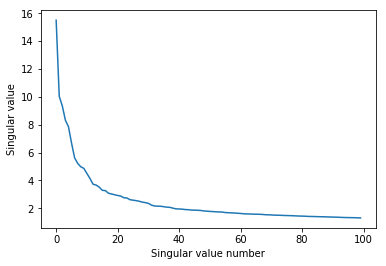

In [19]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

### Looks data lives in about 30 dimensions, take 50 to be safe

In [36]:
words_compressed, _, docs_compressed = svds(prod_vocab_mat, k=50)
docs_compressed = docs_compressed.transpose()

In [37]:
print(words_compressed.shape)
print(docs_compressed.shape)

(5000, 50)
(1492, 50)


In [38]:
word_to_index = vectorizer.vocabulary_
index_to_word = {i:t for t,i in word_to_index.items()}
print(words_compressed.shape)

(5000, 50)


In [39]:
#row normalize
from sklearn.preprocessing import normalize
words_compressed = normalize(words_compressed, axis = 1)

In [40]:
def closest_words(word_in, k = 10):
    if word_in not in word_to_index: return "Not in vocab."
    sims = words_compressed.dot(words_compressed[word_to_index[word_in],:])
    asort = np.argsort(-sims)[:k+1]
    return [(index_to_word[i],sims[i]/sims[asort[0]]) for i in asort[1:]]

In [41]:
closest_words('hydrating')

[('hydrated', 0.8545078710928079),
 ('hydrate', 0.8061315161165756),
 ('hydration', 0.8052614890510366),
 ('hydrates', 0.7947853366486191),
 ('dehydrated', 0.7423670901760779),
 ('moisturizing', 0.711995840656036),
 ('extremely', 0.7013124855394793),
 ('drank', 0.701138295875233),
 ('moisture', 0.6941020385510934),
 ('driest', 0.6763073723035582)]

### Search for similar products

In [42]:
docs_compressed = normalize(docs_compressed, axis = 1)
def closest_products(project_index_in, k = 5):
    sims = docs_compressed.dot(docs_compressed[project_index_in,:])
    asort = np.argsort(-sims)[:k+1]
    return [(list(product_dict.keys())[i] ,sims[i]/sims[asort[0]]) for i in asort[1:]]

In [43]:
print(closest_products(0))

[('P415979', 0.6663078137563629), ('P379707', 0.6654513112875254), ('P440981', 0.6529109750742108), ('P400206', 0.627044832675047), ('P422012', 0.6204320403517511)]
